In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
data = pd.read_csv('D:/Major Project/Dataset/Dynamics/A1237_10deg.csv')

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22396 entries, 0 to 22395
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Current(A)      22396 non-null  float64
 1   Voltage(V)      22396 non-null  float64
 2   Temperature(C)  22396 non-null  float64
 3   OCV             22396 non-null  float64
 4   SOC             22396 non-null  float64
dtypes: float64(5)
memory usage: 875.0 KB


In [5]:
data.head()

,Current(A),Voltage(V),Temperature(C),OCV,SOC
0,0.000000,2.968602,9.646121,2.968602,47.0
1,-1.099185,2.729152,9.690903,2.718161,27.0
2,-1.099373,2.703299,9.598107,2.692306,24.0
3,-1.099373,2.678369,9.797547,2.667376,22.0
4,-1.099373,2.654363,9.766615,2.643369,20.0


In [6]:
data.describe()

,Current(A),Voltage(V),Temperature(C),OCV,SOC
count,22396.000000,22396.000000,22396.000000,22396.000000,22396.000000
mean,-0.400070,3.168700,10.244238,3.164699,63.723210
std,0.917655,0.197940,0.324819,0.205837,17.154298
min,-3.849407,2.413067,9.598107,2.403637,0.000000
25%,-0.910790,3.070168,10.027921,3.062702,55.000000
50%,-0.374908,3.186199,10.179319,3.182508,65.000000
75%,0.000378,3.278224,10.399918,3.278534,73.000000
max,2.061073,3.591232,11.382861,3.599771,100.000000


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [8]:
x = data.iloc[:,:-2]
y = data.iloc[:,-1]

In [9]:
scaler = MinMaxScaler()
x = scaler.fit_transform(x)

In [10]:
x = x.reshape(22396,3,1)

In [11]:
x

array([[[0.65128501],
        [0.47152573],
        [0.02690213]],

       [[0.46531288],
        [0.26828644],
        [0.05199337]],

       [[0.46528109],
        [0.24634287],
        [0.        ]],

       ...,

       [[0.40804652],
        [0.10449321],
        [0.75745545]],

       [[0.65115836],
        [0.19487982],
        [0.71505784]],

       [[0.65128501],
        [0.44252875],
        [0.62663657]]])

In [12]:
y = np.array(y).reshape(22396,1)

In [13]:
y

array([[47.],
       [27.],
       [24.],
       ...,
       [10.],
       [20.],
       [45.]])

In [14]:
train_input, test_input, train_soc, test_soc = train_test_split(x,y,test_size=0.2, random_state=42)

In [15]:
for i in range(len(train_soc)):
    if train_soc[i] == 0:
        train_soc[i] = 1

In [16]:
for i in range(len(test_soc)):
    if test_soc[i] == 0:
        test_soc[i] = 1

In [17]:
train_input.shape

(17916, 3, 1)

In [18]:
test_input.shape

(4480, 3, 1)

In [19]:
train_soc.shape

(17916, 1)

In [20]:
test_soc.shape

(4480, 1)

In [21]:
from keras.models import Sequential
from keras.layers import  Dense, RepeatVector, TimeDistributed, GRU,Flatten
from keras.optimizers import Adam

In [22]:
# Define the model
model = Sequential()

# Encoder
model.add(Dense(16, input_shape=(3,1),activation='tanh'))
model.add(Dense(32, activation='tanh'))
model.add(Dense(64, activation='tanh'))
model.add(Flatten())

# Repeat the context vector to be the input for the decoder
model.add(RepeatVector(1))

# Decoder
model.add(GRU(64, return_sequences=True,activation='sigmoid'))
model.add(GRU(32, return_sequences=True,activation='sigmoid'))
model.add(GRU(16, return_sequences=True,activation='sigmoid'))
model.add(TimeDistributed(Dense(1, activation='linear')))  # Output sequence for regression

In [23]:
# Compile the model with optimizer and loss function
model.compile(optimizer='adam', loss='mse',metrics=['mae'])

In [24]:
# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 3, 16)             32        
                                                                 
 dense_1 (Dense)             (None, 3, 32)             544       
                                                                 
 dense_2 (Dense)             (None, 3, 64)             2112      
                                                                 
 flatten (Flatten)           (None, 192)               0         
                                                                 
 repeat_vector (RepeatVecto  (None, 1, 192)            0         
 r)                                                              
                                                                 
 gru (GRU)                   (None, 1, 64)             49536     
                                                        

In [25]:
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score,mean_absolute_percentage_error
import time

In [26]:
# Train the model
a1 = time.time()
history = model.fit(train_input, train_soc, epochs=500, batch_size=256,validation_split=0.05)
a2 = time.time()
a = a2-a1

Epoch 1/500
67/67 [==============================] - 4s 15ms/step - loss: 4208.7192 - mae: 62.5501 - val_loss: 4020.7603 - val_mae: 61.0543
Epoch 2/500
67/67 [==============================] - 0s 6ms/step - loss: 3945.3625 - mae: 60.4132 - val_loss: 3833.9956 - val_mae: 59.5073
Epoch 3/500
67/67 [==============================] - 0s 6ms/step - loss: 3798.4685 - mae: 59.1903 - val_loss: 3713.8984 - val_mae: 58.4919
Epoch 4/500
67/67 [==============================] - 0s 6ms/step - loss: 3688.5339 - mae: 58.2594 - val_loss: 3612.0737 - val_mae: 57.6207
Epoch 5/500
67/67 [==============================] - 0s 6ms/step - loss: 3590.4307 - mae: 57.4152 - val_loss: 3517.8459 - val_mae: 56.8025
Epoch 6/500
67/67 [==============================] - 0s 6ms/step - loss: 3498.5056 - mae: 56.6155 - val_loss: 3428.6411 - val_mae: 56.0168
Epoch 7/500
67/67 [==============================] - 0s 6ms/step - loss: 3410.8411 - mae: 55.8419 - val_loss: 3342.9597 - val_mae: 55.2523
Epoch 8/500
67/67 [=======

Epoch 60/500
67/67 [==============================] - 0s 6ms/step - loss: 690.0516 - mae: 22.9369 - val_loss: 668.6965 - val_mae: 22.4712
Epoch 61/500
67/67 [==============================] - 0s 7ms/step - loss: 668.6483 - mae: 22.5181 - val_loss: 647.9598 - val_mae: 22.0727
Epoch 62/500
67/67 [==============================] - 0s 6ms/step - loss: 648.0732 - mae: 22.1062 - val_loss: 627.9859 - val_mae: 21.6813
Epoch 63/500
67/67 [==============================] - 0s 6ms/step - loss: 628.2484 - mae: 21.7037 - val_loss: 608.7568 - val_mae: 21.2980
Epoch 64/500
67/67 [==============================] - 0s 6ms/step - loss: 609.2038 - mae: 21.3104 - val_loss: 590.2969 - val_mae: 20.9241
Epoch 65/500
67/67 [==============================] - 0s 6ms/step - loss: 590.8976 - mae: 20.9255 - val_loss: 572.5047 - val_mae: 20.5568
Epoch 66/500
67/67 [==============================] - 0s 6ms/step - loss: 573.3152 - mae: 20.5489 - val_loss: 555.5641 - val_mae: 20.2026
Epoch 67/500
67/67 [==============

67/67 [==============================] - 1s 8ms/step - loss: 295.8093 - mae: 12.8477 - val_loss: 293.1914 - val_mae: 12.7328
Epoch 179/500
67/67 [==============================] - 1s 8ms/step - loss: 295.8075 - mae: 12.8498 - val_loss: 293.1855 - val_mae: 12.7346
Epoch 180/500
67/67 [==============================] - 1s 8ms/step - loss: 295.8058 - mae: 12.8472 - val_loss: 293.1939 - val_mae: 12.7321
Epoch 181/500
67/67 [==============================] - 0s 7ms/step - loss: 295.8065 - mae: 12.8491 - val_loss: 293.1860 - val_mae: 12.7344
Epoch 182/500
67/67 [==============================] - 1s 8ms/step - loss: 295.8097 - mae: 12.8450 - val_loss: 293.1959 - val_mae: 12.7315
Epoch 183/500
67/67 [==============================] - 1s 8ms/step - loss: 295.8104 - mae: 12.8509 - val_loss: 293.1848 - val_mae: 12.7348
Epoch 184/500
67/67 [==============================] - 0s 7ms/step - loss: 295.8079 - mae: 12.8509 - val_loss: 293.1899 - val_mae: 12.7332
Epoch 185/500
67/67 [====================

67/67 [==============================] - 1s 9ms/step - loss: 0.1199 - mae: 0.2808 - val_loss: 0.1116 - val_mae: 0.2688
Epoch 300/500
67/67 [==============================] - 1s 10ms/step - loss: 0.1345 - mae: 0.2958 - val_loss: 0.2192 - val_mae: 0.3777
Epoch 301/500
67/67 [==============================] - 1s 8ms/step - loss: 0.1444 - mae: 0.3070 - val_loss: 0.1864 - val_mae: 0.3454
Epoch 302/500
67/67 [==============================] - 0s 7ms/step - loss: 0.1130 - mae: 0.2748 - val_loss: 0.1086 - val_mae: 0.2704
Epoch 303/500
67/67 [==============================] - 1s 8ms/step - loss: 0.1041 - mae: 0.2674 - val_loss: 0.1127 - val_mae: 0.2734
Epoch 304/500
67/67 [==============================] - 1s 8ms/step - loss: 0.1275 - mae: 0.2902 - val_loss: 0.1464 - val_mae: 0.3071
Epoch 305/500
67/67 [==============================] - 0s 7ms/step - loss: 0.1122 - mae: 0.2755 - val_loss: 0.1556 - val_mae: 0.3161
Epoch 306/500
67/67 [==============================] - 1s 8ms/step - loss: 0.1173 

67/67 [==============================] - 1s 12ms/step - loss: 0.1109 - mae: 0.2774 - val_loss: 0.1169 - val_mae: 0.2841
Epoch 422/500
67/67 [==============================] - 1s 8ms/step - loss: 0.1137 - mae: 0.2803 - val_loss: 0.0933 - val_mae: 0.2608
Epoch 423/500
67/67 [==============================] - 1s 8ms/step - loss: 0.1078 - mae: 0.2748 - val_loss: 0.0919 - val_mae: 0.2590
Epoch 424/500
67/67 [==============================] - 1s 8ms/step - loss: 0.0972 - mae: 0.2641 - val_loss: 0.1604 - val_mae: 0.3272
Epoch 425/500
67/67 [==============================] - 1s 11ms/step - loss: 0.0968 - mae: 0.2630 - val_loss: 0.1041 - val_mae: 0.2714
Epoch 426/500
67/67 [==============================] - 1s 12ms/step - loss: 0.0975 - mae: 0.2640 - val_loss: 0.1477 - val_mae: 0.3146
Epoch 427/500
67/67 [==============================] - 1s 9ms/step - loss: 0.0963 - mae: 0.2630 - val_loss: 0.0864 - val_mae: 0.2527
Epoch 428/500
67/67 [==============================] - 1s 11ms/step - loss: 0.10

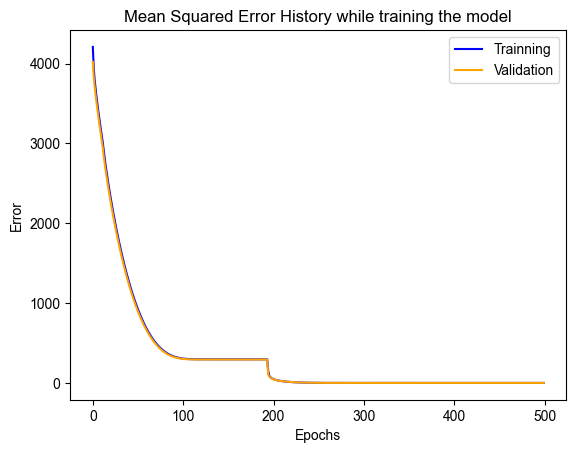

In [27]:
plt.plot(history.history['loss'],color='blue',label='Trainning')
plt.plot(history.history['val_loss'],color='orange',label='Validation')
plt.title('Mean Squared Error History while training the model')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.legend()
sns.set_style('whitegrid')
plt.show()

In [28]:
# Make predictions
predictions = model.predict(test_input)

140/140 [==============================] - 1s 2ms/step


In [29]:
predictions.shape

(4480, 1, 1)

In [30]:
test_soc.shape

(4480, 1)

In [31]:
test_soc = test_soc.reshape(4480,)
y_pred = predictions.reshape(4480,)

In [32]:
mse = mean_squared_error(test_soc, y_pred)
mae = mean_absolute_error(test_soc, y_pred)
mape = mean_absolute_percentage_error(test_soc,y_pred)
rmse = math.sqrt(mse)
r2 = r2_score(test_soc, y_pred)

In [33]:
print(f'Mean Squared Error on Test Set: {mse}')
print(f'Mean Squared Error on Test Set: {rmse}')
print(f'Mean Absolute Error on Test Set: {mae}')
print(f'Mean Absolute Percentage Error on Test Set: {mape*100}')
print(f'R2 Score : {r2}')

Mean Squared Error on Test Set: 0.0847755063336776
Mean Squared Error on Test Set: 0.29116233673618847
Mean Absolute Error on Test Set: 0.25126147270202637
Mean Absolute Percentage Error on Test Set: 0.48599468575795557
R2 Score : 0.9997061645275827


In [34]:
print(f'Time taken for fitting the model is {a/60} mins')

Time taken for fitting the model is 4.670525471369426 mins


In [35]:
Residual = test_soc - y_pred

In [36]:
df = pd.DataFrame({'Actual': test_soc , 'Predicted': y_pred}).sort_values('Actual',ascending=False)
df.head()

,Actual,Predicted
2749,100.0,99.690910
2075,100.0,99.704475
1261,100.0,99.783615
634,100.0,99.555031
89,100.0,99.741745


In [37]:
df.tail()

,Actual,Predicted
4170,3.0,3.155621
2096,2.0,2.117546
1697,1.0,1.875832
4344,1.0,1.371768
1783,1.0,1.047242


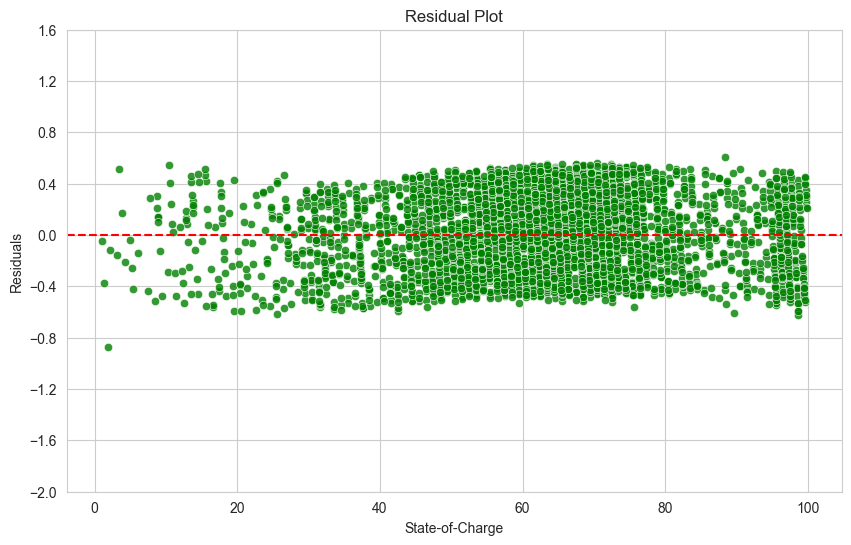

In [38]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred, y=Residual, color='green', alpha=0.8)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residual Plot')
plt.xlabel('State-of-Charge')
plt.ylabel('Residuals')
plt.ylim(-1.6, 1)  # Set y-axis limits
plt.yticks([i * 0.4 for i in range(-5, 5)])  # Set y-axis ticks
plt.show()

In [39]:
# Save the model to a file
model.save("10deg.h5")